<a href="https://colab.research.google.com/github/M-Pascal/NeoParental/blob/main/Model/Capstone_project_%5BNeoParental%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Description:**
NeoParental is an AI-powered mobile application designed to support infant care in Rwanda by analyzing and interpreting baby cries. The system helps parents and caregivers understand their infants’ needs, offers real-time guidance, and integrates with Community Health Workers to strengthen early health interventions and improve maternal and child well-being.

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import librosa
import librosa.display
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# Loading the data
data = "/content/drive/MyDrive/Y3_T3/capstone_project/Sound_data"


In [ ]:
# Dictionary to hold file paths grouped by label
audio_files = {}

# Looping through each subdirectory
for label in os.listdir(data):
    label_path = os.path.join(data, label)
    if os.path.isdir(label_path):
        files = [os.path.join(label_path, f)
                 for f in os.listdir(label_path) if f.endswith(".wav")]
        audio_files[label] = files

# Check what we got
for label, files in audio_files.items():
    print(f"{label}: {len(files)} files")

discomfort: 27 files
belly_pain: 16 files
burping: 8 files
tired: 24 files
hungry: 382 files


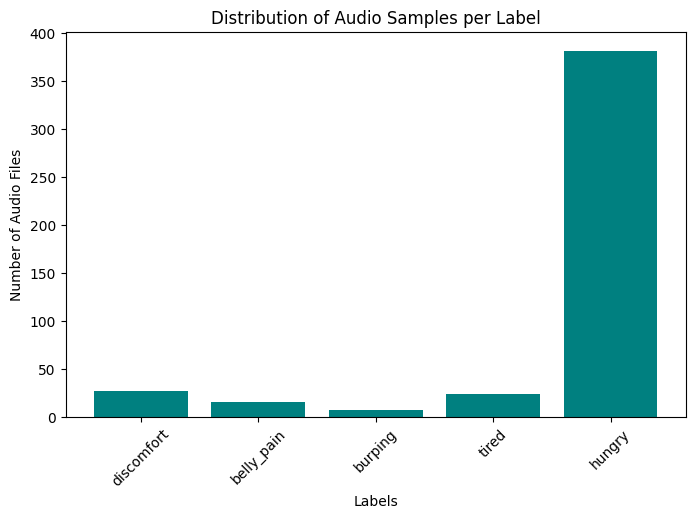

In [ ]:
labels = list(audio_files.keys())
counts = [len(audio_files[label]) for label in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='teal')
plt.xlabel("Labels")
plt.ylabel("Number of Audio Files")
plt.title("Distribution of Audio Samples per Label")
plt.xticks(rotation=45)
plt.savefig('audios.png')
plt.show()

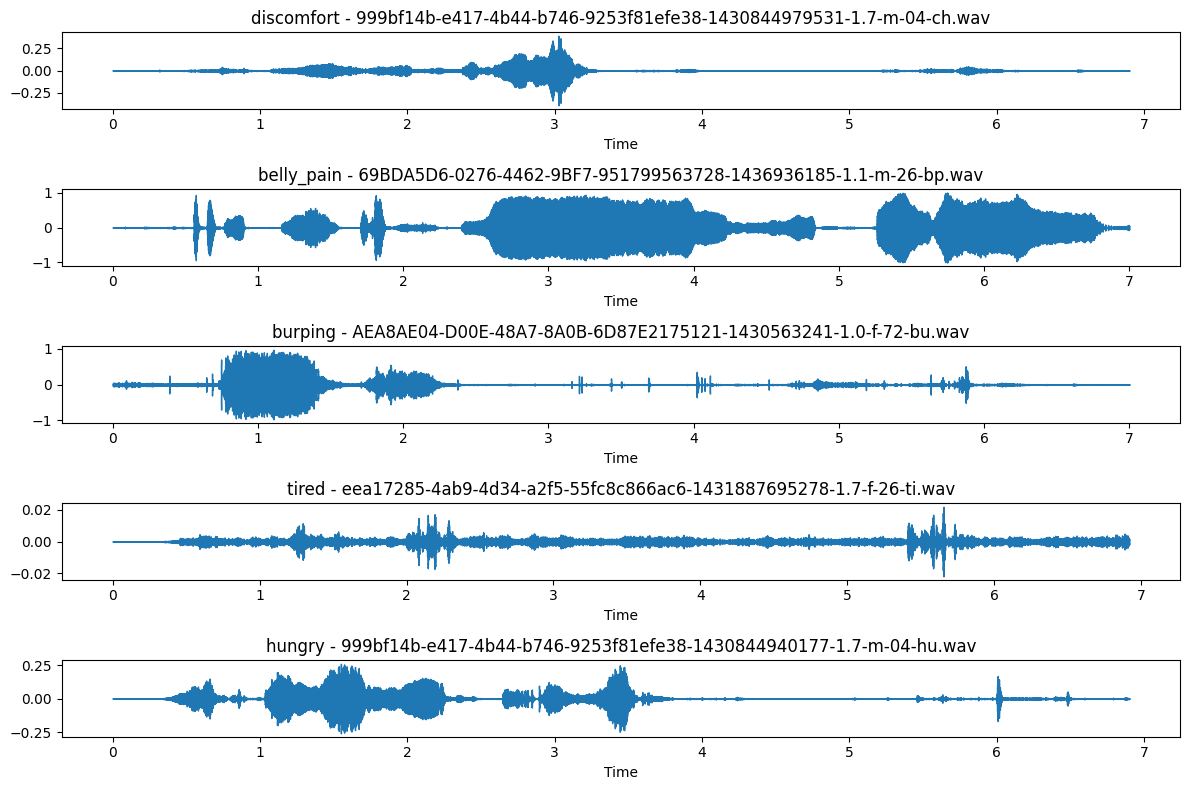

In [ ]:
plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    # Pick a random file from this label
    sample_file = random.choice(audio_files[label])
    y, sr = librosa.load(sample_file, sr=None)

    plt.subplot(len(labels), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{label} - {os.path.basename(sample_file)}")
    plt.tight_layout()

plt.show()

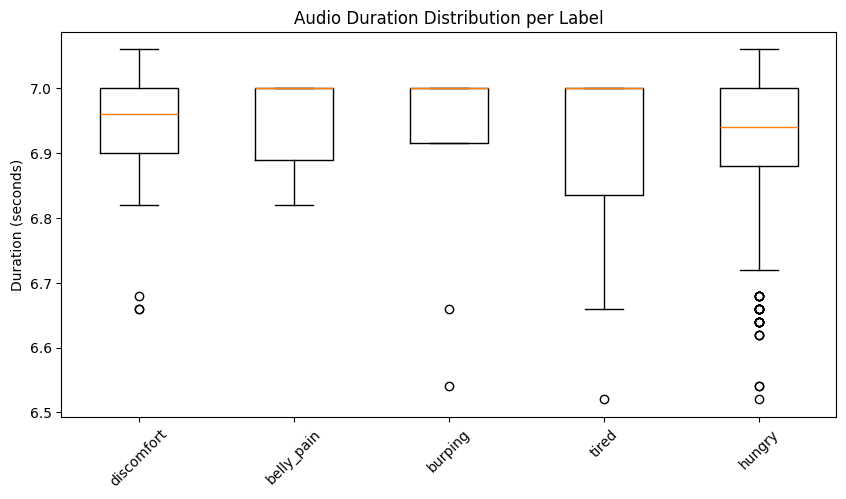

In [ ]:
# Time distrubtion accross the labels

durations = {label: [] for label in labels}

for label, files in audio_files.items():
    for file in files:
        y, sr = librosa.load(file, sr=None)
        durations[label].append(len(y)/sr)

# Boxplot
plt.figure(figsize=(10,5))
plt.boxplot([durations[l] for l in labels], tick_labels=labels)
plt.ylabel("Duration (seconds)")
plt.title("Audio Duration Distribution per Label")
plt.xticks(rotation=45)
plt.show()

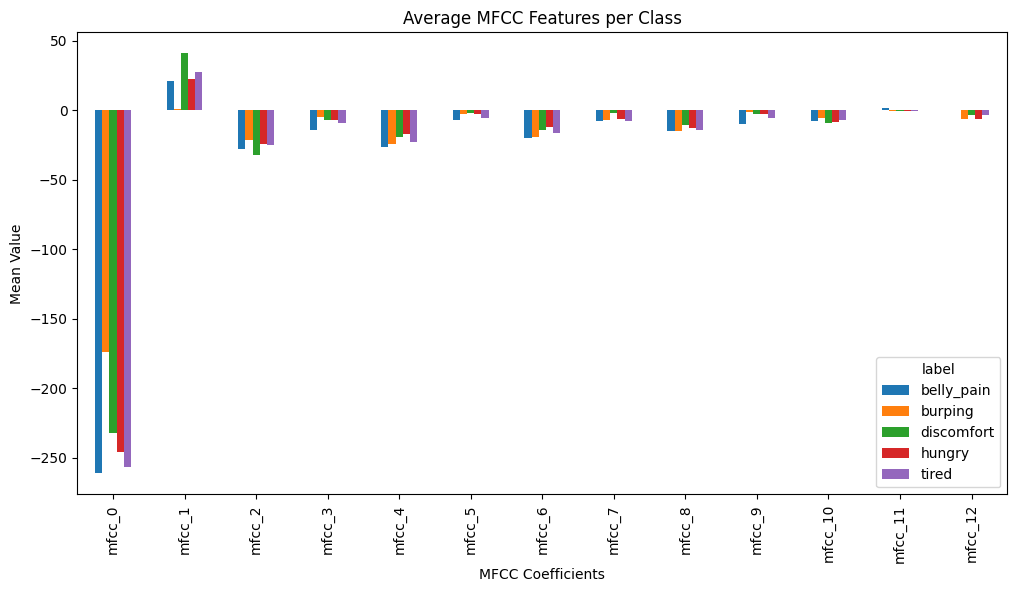

In [ ]:
# Average feature statistics for each class
features_summary = []

for label, files in audio_files.items():
    for file in files[:20]:
        y, sr = librosa.load(file, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mean_mfcc = np.mean(mfcc, axis=1)
        features_summary.append([label] + list(mean_mfcc))

df = pd.DataFrame(features_summary, columns=["label"] + [f"mfcc_{i}" for i in range(13)])
df.groupby("label").mean().T.plot(kind='bar', figsize=(12,6))
plt.title("Average MFCC Features per Class")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Value")
plt.show()

In [ ]:
# Feature extraction parameters
n_mfcc = 40
n_fft = 1024
hop_length = 10*16
win_length = 25*16
window = 'hann'
n_chroma = 12
n_mels = 128
n_bands = 7
fmin = 100

def extract_features(file_path):
    try:
        # Load audio file and extract features
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=n_fft,
                                           hop_length=hop_length, win_length=win_length,
                                           window=window).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                                    hop_length=hop_length, win_length=win_length,
                                                    window='hann', n_mels=n_mels).T, axis=0)
        stft = np.abs(librosa.stft(y))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr, n_fft=n_fft,
                                                           hop_length=hop_length, win_length=win_length,
                                                           n_bands=n_bands, fmin=fmin).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
        features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz))
        return features
    except Exception as e:
        print(f"Error in feature extraction for {file_path}: {e}")
        return None


# Initialize empty lists
features = []
labels = []  # ['hungry', 'tired', 'burping']

# Your target categories
target_categories = ['hungry', 'burping', 'discomfort', 'tired', 'belly_pain']

# Load data from folder structure
print("Loading audio data...")
for category in target_categories:
    category_path = os.path.join(data, category)

    if os.path.exists(category_path):
        print(f"Loading {category} data...")

        for file_name in os.listdir(category_path):
            if file_name.endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(category_path, file_name)

                # Extract features
                feature = extract_features(file_path)
                if feature is not None:
                    features.append(feature)
                    labels.append(category)  # Just store the category name

        print(f"Loaded {category} data")

print(f"\nTotal features extracted: {len(features)}")
print(f"Total labels: {len(labels)}")

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Loading audio data...
Loading hungry data...
Loaded hungry data
Loading burping data...
Loaded burping data
Loading discomfort data...
Loaded discomfort data
Loading tired data...
Loaded tired data
Loading belly_pain data...
Loaded belly_pain data

Total features extracted: 457
Total labels: 457
Features shape: (457, 194)
Labels shape: (457,)


In [ ]:
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [ ]:
# Encode labels to numbers (like 'hungry' -> 0, 'burping' -> 1, etc.)
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_encoded, test_size=0.25, random_state=42
)

print(f"\nTraining set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")



Training set: (1432, 194)
Testing set: (478, 194)


In [ ]:
# Train Decision Tree model (SIMPLE - like your example)
clf = DecisionTreeClassifier(random_state=42)

# Train the model using the training sets
clf = clf.fit(X_train, y_train)

Accuracy of Decision Tree classifier on test set: 0.95

Detailed Classification Report:
              precision    recall  f1-score   support

  belly_pain       0.94      1.00      0.97        91
     burping       0.99      1.00      0.99        95
  discomfort       0.90      1.00      0.95       100
      hungry       1.00      0.77      0.87        96
       tired       0.96      1.00      0.98        96

    accuracy                           0.95       478
   macro avg       0.96      0.95      0.95       478
weighted avg       0.96      0.95      0.95       478



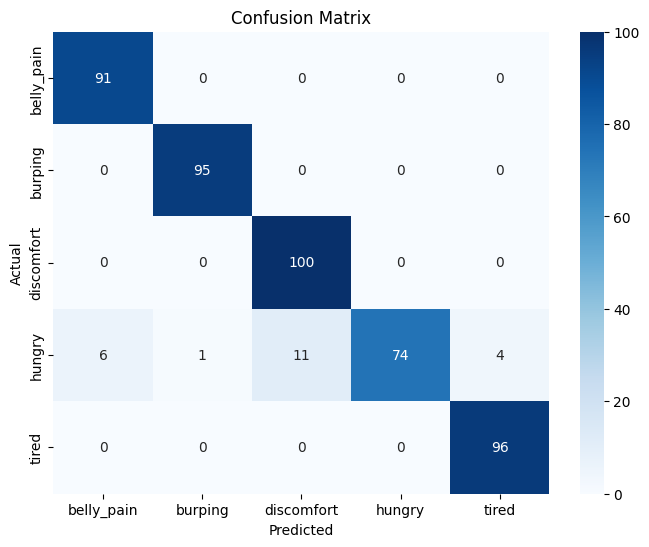

In [ ]:
# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Print model accuracy (just like your example)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
      .format(accuracy_score(y_test, y_pred)))

# More detailed evaluation
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()